In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scanpy
!pip install infercnvpy

In [ ]:
import scanpy as sc
train_path = '/content/drive/MyDrive/stemcell/final_project/PBMC_simulated_cnas_041025.h5ad'

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/stemcell/final_project/final_project')

In [ ]:
import scancnv

In [ ]:
from scancnv.infer import infer_cnv_and_annotate
from scancnv.infer import annotate_cnv
from scancnv.filter_genes import filter_genes_by_chromosome
from scancnv.annotate import annotate_normal_cells
from scancnv.subset import subset_shared_genes
from scancnv.assess import assess_cnv

In [86]:
adata = sc.read(train_path)
adata = filter_genes_by_chromosome(adata)
gene_pos_df = adata.var[['chromosome', 'start', 'end']]
annotate_normal_cells(adata)

/content/drive/MyDrive/stemcell/final_project/final_project/scancnv/annotate.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ct, sub in obs.groupby(celltype_key):


In [79]:
cnv_scores = annotate_cnv(
    adata,
    gene_pos_df,
    celltype_key="cell_type",
    window_size=50,
    thresh_del=-0.1,
    thresh_half=-0.07,
    thresh_gain=0.2,
    min_cells=300,
    min_annots=300
)

In [81]:
assess_cnv(adata)

Accuracy:    0.908
Precision:   0.160
Sensitivity: 0.243


{'TP': 1142,
 'FP': 5975,
 'FN': 3555,
 'TN': 92418,
 'accuracy': 0.9075565040256087,
 'precision': 0.16046086834340312,
 'sensitivity': 0.2431339152650628}

In [ ]:
print(adata.obs['annotated_cnvs'].value_counts())

annotated_cnvs
                                                                                                                      4983
15:100919327-101963416 (CN 1)                                                                                         1131
21:45073853-46665685 (CN 1)                                                                                            342
6:31200165-33418317 (CN 1)                                                                                             306
22:19875517-22287220 (CN 0)                                                                                            305
                                                                                                                      ... 
6:31200165-33418317 (CN 1), 22:19875517-22287220 (CN 0), 21:29024255-34615113 (CN 1)                                     1
10:67849481-72355149 (CN 1), 22:19875517-22287220 (CN 0), 22:25009685-30246759 (CN 1)                                    1
6

# Re-run with different parameters.

window size = 100

In [ ]:
cnv_scores = annotate_cnv(
    adata,
    gene_pos_df,
    celltype_key="cell_type",
    window_size=100,
    thresh_del=-0.1,
    thresh_half=-0.07,
    thresh_gain=0.2,
    min_cells=300,
    min_annots=300
)

In [ ]:
assess_cnv(adata)

Accuracy:    0.931
Precision:   0.133
Sensitivity: 0.150


{'TP': 706,
 'FP': 4583,
 'FN': 3991,
 'TN': 114428,
 'accuracy': 0.9306916286739741,
 'precision': 0.1334845906598601,
 'sensitivity': 0.15030870768575685}

window size = 150

In [ ]:
cnv_scores = annotate_cnv(
    adata,
    gene_pos_df,
    celltype_key="cell_type",
    window_size=200,
    thresh_del=-0.1,
    thresh_half=-0.07,
    thresh_gain=0.2,
    min_cells=300,
    min_annots=300
)

In [ ]:
assess_cnv(adata)

Accuracy:    0.928
Precision:   0.061
Sensitivity: 0.051


{'TP': 241,
 'FP': 3685,
 'FN': 4456,
 'TN': 105017,
 'accuracy': 0.9282092434677555,
 'precision': 0.061385634233316354,
 'sensitivity': 0.051309346391313605}

# impact of read depth

counts per cell = 5000

In [117]:
sc.pp.downsample_counts(adata, counts_per_cell=5000, copy=True)

In [131]:
cnv_scores = annotate_cnv(
    adata,
    gene_pos_df,
    celltype_key="cell_type",
    window_size=50,
    thresh_del=-0.1,
    thresh_half=-0.07,
    thresh_gain=0.2,
    min_cells=300,
    min_annots=300
)

In [132]:
metrics = assess_cnv(adata)

Accuracy:    0.932
Precision:   0.191
Sensitivity: 0.152


counts per cell = 2500

In [94]:
sc.pp.downsample_counts(adata, counts_per_cell=5000, copy=True)

In [97]:
cnv_scores = annotate_cnv(
    adata,
    gene_pos_df,
    celltype_key="cell_type",
    window_size=50,
    thresh_del=-0.1,
    thresh_half=-0.07,
    thresh_gain=0.2,
    min_cells=300,
    min_annots=300
)

In [98]:
assess_cnv(adata)

Accuracy:    0.908
Precision:   0.160
Sensitivity: 0.243


{'TP': 1142,
 'FP': 5975,
 'FN': 3555,
 'TN': 92418,
 'accuracy': 0.9075565040256087,
 'precision': 0.16046086834340312,
 'sensitivity': 0.2431339152650628}

# benchmark method infercnv

In [ ]:
import scanpy as sc
import infercnvpy as cnv

# 1. Prepare AnnData
# Assume `adata` is already loaded, and `adata.obs['celltype']` contains known cell type annotations.
# Typically, certain normal cell types (e.g., B cells, T cells) are used as references.
# Here, we use 'B cell' as the reference group.
reference_categories = ['B cell']  # Replace based on your actual annotations
adata = sc.read(train_path)
adata = filter_genes_by_chromosome(adata)

# 2. Normalize and log-transform (infercnvpy expects raw counts)
# sc.pp.normalize_total(adata, target_sum=1e4)

# 3. Run inferCNV
#    window_size: number of genes per sliding window; can be adjusted
#    cluster: whether to perform additional clustering on cells; usually done separately during visualization
adata.var["chromosome"] = adata.var["chromosome"].astype(str).apply(
    lambda x: x if x.startswith("chr") else "chr" + x
)
cnv.tl.infercnv(
    adata,
    reference_key='cell_type',
    reference_cat=reference_categories,
    window_size=100,
    # gene_order_key='chrom_pos'
)

  0%|          | 0/3 [00:00<?, ?it/s]

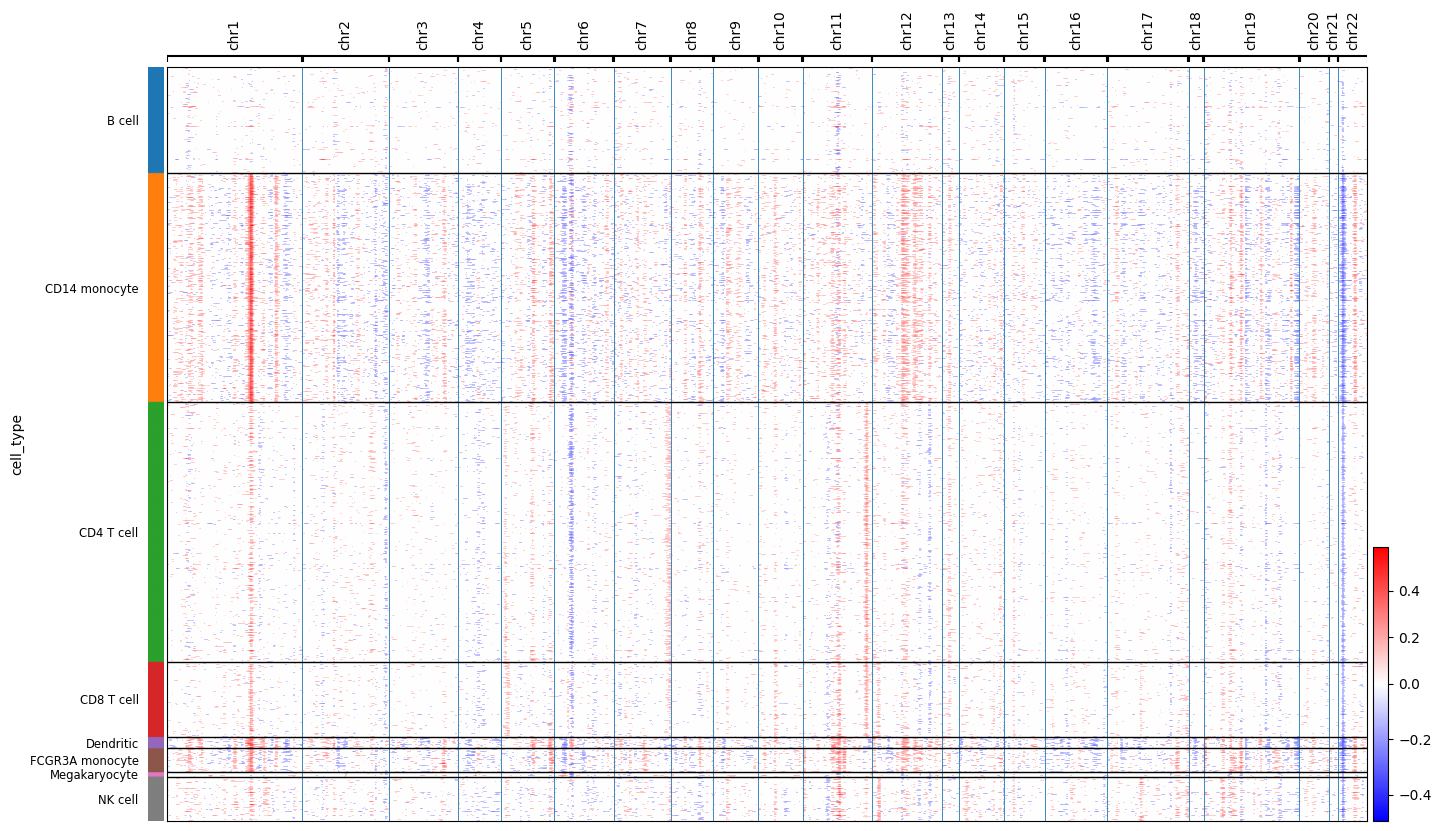

In [ ]:
cnv.pl.chromosome_heatmap(adata, groupby='cell_type')

In [ ]:
import numpy as np
import pandas as pd
from scipy import sparse

# 1. Extract the CNV matrix
X_cnv = adata.obsm['X_cnv']
if sparse.issparse(X_cnv):
    X_cnv = X_cnv.toarray()
n_cells, n_windows = X_cnv.shape

# 2. Read the chromosome position mapping from adata.uns
#    Note: it is stored in adata.uns['cnv']['chr_pos']
chr_pos_map = {k: int(v) for k, v in adata.uns['cnv']['chr_pos'].items()}

# 3. Sort chromosomes in ascending order and compute start/end window indices for each chromosome
chroms = sorted(chr_pos_map.keys(), key=lambda x: int(x.replace('chr','')))
starts = [chr_pos_map[ch] for ch in chroms]
ends   = starts[1:] + [n_windows]

# 4. Build a full gene table sorted by chromosome and start position using gene-level info from var
gene_df = (
    adata.var[['chromosome','start','end']]
    .assign(chromosome=lambda df: df['chromosome']
                             .astype(str)
                             .str.replace(r'^chr','',regex=True))
    .sort_values(['chromosome','start'])
    .reset_index(drop=True)
)

# 5. For each chromosome, reconstruct the true genomic intervals of each window
wins = []
for ch, w0, w1 in zip(chroms, starts, ends):
    # Remove "chr" prefix to match entries in gene_df
    chrom_short = ch.replace('chr','')
    gene_idxs   = gene_df[gene_df['chromosome'] == chrom_short].index.to_numpy()
    n_genes_chr = len(gene_idxs)
    n_win_chr   = w1 - w0

    base = n_genes_chr // n_win_chr
    rem  = n_genes_chr % n_win_chr
    idx0 = gene_idxs[0]

    for i in range(n_win_chr):
        sz      = base + (1 if i < rem else 0)
        gs      = idx0 + (i * base + min(i, rem))
        ge      = gs + sz - 1
        wins.append({
            'chromosome': chrom_short,
            'start'     : int(gene_df.loc[gs, 'start']),
            'end'       : int(gene_df.loc[ge, 'end'])
        })

windows_df = pd.DataFrame(wins)  # Number of rows should equal n_windows

# 6. Traverse each cell × chromosome window to merge consecutive segments with the same CN
annotations = []
for ci in range(n_cells):
    row = X_cnv[ci]
    regs = []

    for ch, w0, w1 in zip(chroms, starts, ends):
        chrom_short = ch.replace('chr','')
        curr_cn = None
        seg0    = None

        for j in range(w0, w1):
            v = row[j]
            if   v <= -0.5:    cn = 0
            elif v <= -0.25:  cn = 1
            elif v >= 0.5:    cn = 4
            else:             cn = 2

            if cn != 2:
                if curr_cn is None:
                    seg0    = j
                    curr_cn = cn
                elif curr_cn != cn:
                    regs.append(
                        f"{chrom_short}:"
                        f"{windows_df.loc[seg0,'start']}-"
                        f"{windows_df.loc[j-1,'end']} "
                        f"(CN{curr_cn})"
                    )
                    seg0    = j
                    curr_cn = cn
            else:
                if curr_cn is not None:
                    regs.append(
                        f"{chrom_short}:"
                        f"{windows_df.loc[seg0,'start']}-"
                        f"{windows_df.loc[j-1,'end']} "
                        f"(CN{curr_cn})"
                    )
                    curr_cn = None

        # Force-close at the chromosome end
        if curr_cn is not None:
            regs.append(
                f"{chrom_short}:"
                f"{windows_df.loc[seg0,'start']}-"
                f"{windows_df.loc[w1-1,'end']} "
                f"(CN{curr_cn})"
            )

    annotations.append(", ".join(regs) if regs else "")

# 7. Write results back to adata.obs
adata.obs['inferred_cnvs'] = annotations

In [ ]:
adata.obs['inferred_cnvs'] = (
    adata.obs['inferred_cnvs']
    .str.replace(r'\s*;\s*', ', ', regex=True)   # Replace semicolon separators with commas and standard spacing
    .str.replace(r'chr', '', regex=True)         # Remove 'chr' prefix
    .str.replace(r'(\d+)\.0', r'\1', regex=True) # Remove trailing '.0' from numbers
)

# First, convert NaN/None values in both fields to empty strings, then ensure both are string dtype
adata.obs[['inferred_cnvs', 'simulated_cnvs']] = (
    adata.obs[['inferred_cnvs', 'simulated_cnvs']]
    .fillna('')     # Convert NaN/None to empty strings
    .astype(str)    # Convert both columns to string type
)

In [ ]:
print(adata.obs['simulated_cnvs'].value_counts())

simulated_cnvs
                                                           6312
X:106533974-112956833 (CN 4)                               1731
6:25435484-35035259 (CN 1)                                  895
22:19807132-29743868 (CN 0), 6:25435484-35035259 (CN 1)     700
22:19807132-29743868 (CN 0)                                 671
Name: count, dtype: int64


In [ ]:
print(adata.obs['inferred_cnvs'].value_counts())

inferred_cnvs
                                                           8929
22:20999104-22410282 (CN1)                                  233
22:20999104-22919851 (CN1)                                  177
22:20999104-21700015 (CN1)                                   86
6:31730581-32589848 (CN1)                                    86
                                                           ... 
1:154974653-155255483 (CN4), 22:20320104-22410282 (CN1)       1
1:154974653-155134899 (CN4), 22:20999104-22919851 (CN1)       1
2:94791103-95835003 (CN1), 22:20999104-22410282 (CN1)         1
19:57449689-58573575 (CN1), 22:20999104-22919851 (CN1)        1
19:57848731-58573575 (CN1), 22:19969896-23754425 (CN1)        1
Name: count, Length: 240, dtype: int64


In [ ]:
metrics = assess_cnv(adata,pred_key='inferred_cnvs',label_key='simulated_cnvs')

Accuracy:    0.971
Precision:   0.059
Sensitivity: 0.018
